In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords

In [22]:
#read data
df_read = pd.read_csv('fake-news/train.csv')

In [23]:
df_read.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [24]:
df_read.count()

id        20800
title     20242
author    18843
text      20761
label     20800
dtype: int64

In [25]:
#check for null values
df_read.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [26]:
#Use stemming to simplify data
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_words(text):
    word_list  = []
    for word in text.split():
        word_list.append(stemmer.stem(word))
    return " ".join(word_list)

In [27]:
def text_cleaning(df):
    df.text = df.text.fillna(df_read['title']) #fill title where text is null
    df.title = df.title.fillna(df_read['text']) #fill text where title is null
    df.author = df.author.fillna('Author is unkown') # fill author as unknown where it is null
    stop = stopwords.words('english')
    df = df.apply(lambda x: x.astype(str).str.lower()) # make everythin null for easy processing
    df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove stop words
    df['title']= df['title'].apply(stem_words) #apply stemming on title
    df['total'] = df['title'] + " " + df['author'] #get final text as title and author
    return df
        

In [28]:
df_read = text_cleaning(df_read)

In [29]:
df_read.head()

,id,title,author,text,label,total
0,0,hous dem aide: didn’t even see comey’ letter j...,darrell lucus,house dem aide: we didn’t even see comey’s let...,1,hous dem aide: didn’t even see comey’ letter j...
1,1,"flynn: hillari clinton, big woman campu - brei...",daniel j. flynn,ever get the feeling your life circles the rou...,0,"flynn: hillari clinton, big woman campu - brei..."
2,2,truth might get fire,consortiumnews.com,"why the truth might get you fired october 29, ...",1,truth might get fire consortiumnews.com
3,3,15 civilian kill singl us airstrik identifi,jessica purkiss,videos 15 civilians killed in single us airstr...,1,15 civilian kill singl us airstrik identifi je...
4,4,iranian woman jail fiction unpublish stori wom...,howard portnoy,print \nan iranian woman has been sentenced to...,1,iranian woman jail fiction unpublish stori wom...


In [30]:
#convert lable dtype to int
df_read['label'] = df_read['label'].astype(int)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


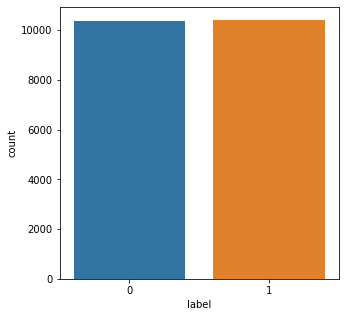

In [31]:
plt.figure(figsize=(5,5))
sns.countplot(df_read['label'],data=df_read)
plt.show()

In [32]:
df = df_read.copy()

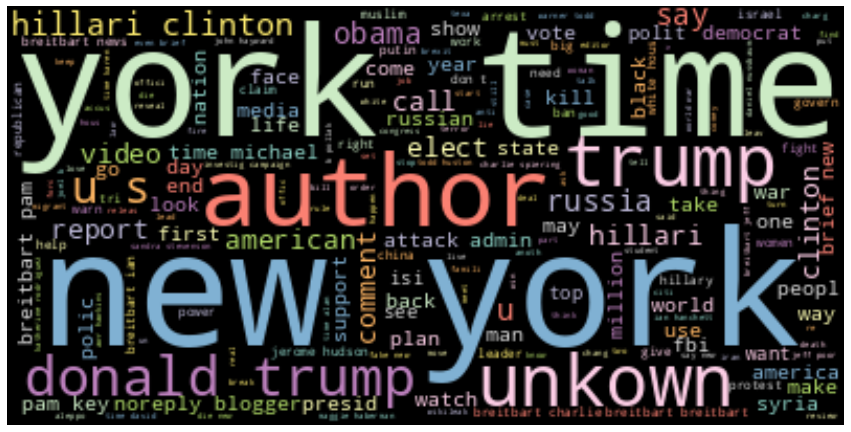

In [33]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df.total.unique())
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [34]:
x = df['total']
y= df['label']

In [35]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [36]:
#tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_to_index = tokenizer.word_index
x = tokenizer.texts_to_sequences(x)

In [37]:
vocab_size =  len(word_to_index)
embedding_dim = 300

In [38]:
#apply padding with max length for sentence as 500
max_length = 500
x = pad_sequences(x,maxlen= max_length)

In [39]:
%%time
#use glove embedding for vector creation
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.
CPU times: user 29.8 s, sys: 1.28 s, total: 31 s
Wall time: 44 s


In [40]:
%%time
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CPU times: user 37.4 ms, sys: 36 ms, total: 73.4 ms
Wall time: 73.1 ms


In [42]:
#model architecture
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim,input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

   
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          8617200   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [43]:
#split data ito train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=1)

In [44]:
#train the model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
260/260 [==============================] - 33s 113ms/step - loss: 0.1464 - accuracy: 0.9434 - val_loss: 0.0605 - val_accuracy: 0.9803
Epoch 2/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0372 - accuracy: 0.9875 - val_loss: 0.0329 - val_accuracy: 0.9906
Epoch 3/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0332 - val_accuracy: 0.9913
Epoch 4/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0322 - val_accuracy: 0.9930
Epoch 5/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0276 - val_accuracy: 0.9942
Epoch 6/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.0335 - val_accuracy: 0.9940
Epoch 7/10
260/260 [==============================] - 29s 111ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0325 - val_ac

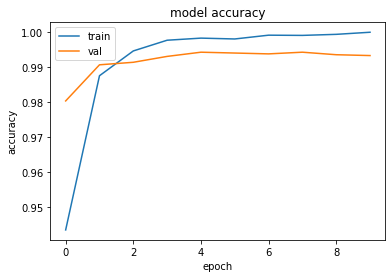

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
predictions = model.predict(X_test)
predictions = [int(np.round(pred[0])) for pred in predictions]

In [47]:
#get precision, recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2052
           1       0.99      1.00      0.99      2108

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



In [48]:
#read test data
test = pd.read_csv('fake-news/test.csv')

In [49]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [50]:
%%time
df_test = text_cleaning(test)

CPU times: user 2.24 s, sys: 13.8 ms, total: 2.26 s
Wall time: 2.26 s


In [51]:
df_test.head()

,id,title,author,text,total
0,20800,"specter trump loosen tongues, purs strings, si...",david streitfeld,"palo alto, calif. — after years of scorning...","specter trump loosen tongues, purs strings, si..."
1,20801,russian warship readi strike terrorist near al...,author is unkown,russian warships ready to strike terrorists ne...,russian warship readi strike terrorist near al...
2,20802,#nodapl: nativ american leader vow stay winter...,common dreams,videos #nodapl: native american leaders vow to...,#nodapl: nativ american leader vow stay winter...
3,20803,"tim tebow attempt anoth comeback, time basebal...",daniel victor,"if at first you don’t succeed, try a different...","tim tebow attempt anoth comeback, time basebal..."
4,20804,keiser report: meme war (e995),truth broadcast network,42 mins ago 1 views 0 comments 0 likes 'for th...,keiser report: meme war (e995) truth broadcast...


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   object
 1   title   5200 non-null   object
 2   author  5200 non-null   object
 3   text    5200 non-null   object
 4   total   5200 non-null   object
dtypes: object(5)
memory usage: 203.2+ KB


In [53]:
test_file = df_test['total']

In [54]:
#use same tokenizer for test data
test_file = tokenizer.texts_to_sequences(test_file)
from keras.preprocessing.sequence import pad_sequences
max_length = 500
test_file = pad_sequences(test_file,maxlen= max_length)

In [55]:
predictions = model.predict(test_file)
predictions = [int(np.round(pred[0])) for pred in predictions]

In [56]:
submission = pd.DataFrame({
    "id" : df_test["id"],
    "label" : predictions
})

In [57]:
submission

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


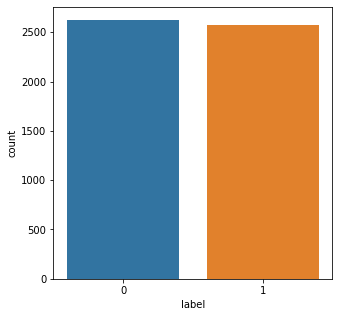

In [58]:
plt.figure(figsize=(5,5))
sns.countplot(submission['label'],data=submission)
plt.show()

In [59]:
#save submission file
submission.to_csv('submission.csv',index=False)